# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
import numpy as np
from torchviz import make_dot

from modules.helper_functions_tsp import (find_problem_size,
load_dict_from_json, read_file_name, validate_distance_array,
cost_fn_fact, cost_fn_tensor, hot_start, hot_start_list_to_string)

from modules.config import NETWORK_DIR, DATA_SOURCES, GRAPH_DIR
from modules.helper_ML_functions import find_device
from modules.graph_functions import (plot_sine_activation,
                                     plot_model_training)

Set up constants:

In [2]:
LOCATIONS = 8                       #locations in problem
DECODING_FORMULATION = 'original'   #decoding formulation
                                    #options: 'original', 'new'
GRAY = False                        #gray code  
STD_DEV = 0.1                       #standard deviation for weight randomization
NUM_EPOCHS = 1000                   #number of epochs for training
NUM_LAYERS = 2                      #number of layers in the mode
LR = 0.0001                         #Learning rate
VERBOSE = False                     #controls how much output the model produces
BATCH_SIZE = 64                     #size of input tensor.  Reduces randomness
MOMENTUM = 0.0                      #momentum for optimizer
WEIGHT_DECAY = 0.0002               #importance of L2 regularization in optimiser
OPTIMIZER = 'SGD'                   #optimizer to use
                                    #options: 'Adam', 'SGD'
     

Read in data and report on data read:

In [3]:
sources_filename = Path(NETWORK_DIR).joinpath(DATA_SOURCES)
data_source_dict = load_dict_from_json(sources_filename)
filename = read_file_name(str(LOCATIONS), data_source_dict)
filepath = Path(NETWORK_DIR).joinpath(filename)
best_dist = data_source_dict[str(LOCATIONS)]['best']
print(f'Data will be read from filename {filepath}.  It is known that the shortest distance is {best_dist}.')

Reading distance data
Data will be read from filename networks\sim_dist_8_locs.txt.  It is known that the shortest distance is 277.2.


Read in and validate distance array:

In [4]:
distance_array = np.genfromtxt(filepath)
validate_distance_array(distance_array, LOCATIONS)

Evaluate cost function and clear cache:

In [5]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array, GRAY, method = DECODING_FORMULATION, verbose=VERBOSE)
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [6]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [7]:
qubits = find_problem_size(LOCATIONS, DECODING_FORMULATION)
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the {DECODING_FORMULATION} formulation.')

There are 14 qubits needed for 8 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [8]:
hot_start_list = hot_start(distance_array, LOCATIONS)
print(f'The hot start location list is {hot_start_list}')
bin_hot_start_list =  hot_start_list_to_string(hot_start_list, LOCATIONS, GRAY, DECODING_FORMULATION)
print(f'This is equivalent to a binary list: {bin_hot_start_list}')
bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
print(f'The hot start distance is {float(distance_tensor):.2f}, compared to a best distance of {best_dist:.2f}.')

The hot start location list is [0, 3, 5, 4, 1, 6, 7, 2]
This is equivalent to a binary list: [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]
bin_hot_start_list_tensor = tensor([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1]])
The hot start distance is 315.80, compared to a best distance of 277.20.


Set up input as repeated hot start tensor calculated above:

In [9]:
unrepeated_input = bin_hot_start_list_tensor.float().to(device)
my_input = unrepeated_input.repeat(BATCH_SIZE, 1).requires_grad_(True)

Set up model with gradient required:

In [10]:

model = MyModel(qubits, NUM_LAYERS, STD_DEV, cost_fn).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [11]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 420 parameters in total, of which 420 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

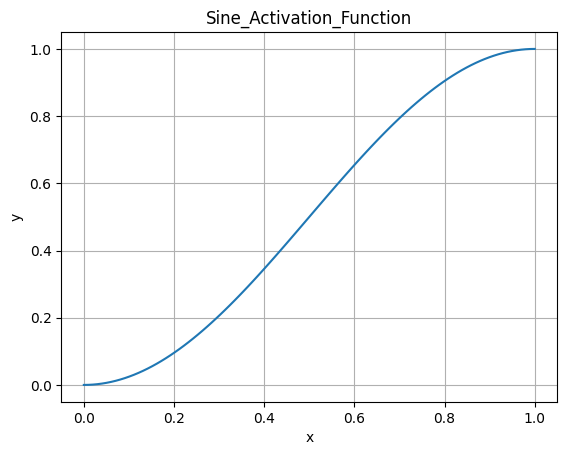

In [12]:
plot_sine_activation()

Print out model details including graph

Output = 412.6781311035156
{'fc1.weight': Parameter containing:
tensor([[ 9.5864e-01, -7.8681e-02,  5.6178e-02,  5.8680e-02,  5.5613e-02,
          9.1608e-02,  5.4412e-02,  2.6995e-02, -6.6763e-02,  8.0417e-02,
         -1.5605e-02, -4.3030e-02,  1.2376e-02, -1.8643e-01],
        [-3.0803e-02,  9.8366e-01,  1.3924e-02, -1.0666e-01,  1.2743e-01,
          1.6023e-01, -1.0796e-01,  1.8974e-01,  3.9632e-01, -6.3221e-02,
          3.6557e-03,  2.4580e-02, -1.0185e-01, -1.2150e-02],
        [-5.4392e-02,  3.8332e-02,  8.6896e-01, -1.1845e-01,  5.6944e-02,
         -1.4800e-01,  8.9873e-02, -5.5826e-02, -2.4314e-02, -3.7477e-02,
         -4.9388e-02, -5.4584e-02, -1.0618e-02,  7.6057e-02],
        [ 7.3467e-02,  6.4586e-02,  1.4097e-01,  1.2455e+00,  4.6463e-02,
          9.3201e-02,  6.7486e-02, -5.2413e-02, -6.6536e-04,  5.8073e-02,
         -4.1874e-02, -6.9375e-03,  1.5133e-01, -1.3718e-02],
        [ 3.8824e-02, -2.8119e-02, -1.9337e-01, -4.5102e-02,  1.0028e+00,
          1.3211e-01, 

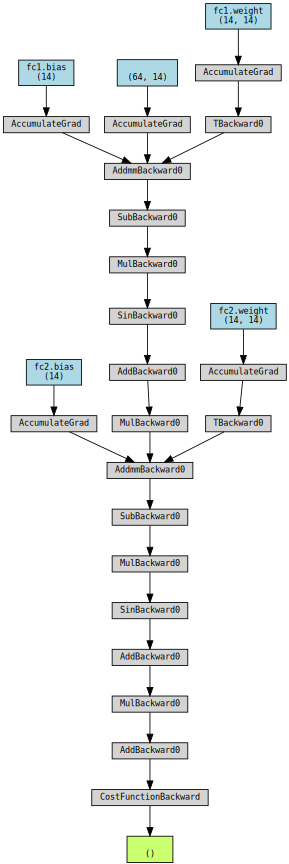

In [13]:
output = model(my_input)
lowest_cost = float(output)
print(f'Output = {output}')
filename = Path(GRAPH_DIR).joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

In [14]:
target = torch.tensor(0.0, requires_grad=True)
criterion = nn.L1Loss()
if OPTIMIZER == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
elif OPTIMIZER == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), momentum=MOMENTUM, lr=LR, weight_decay=WEIGHT_DECAY)
else:
    raise ValueError(f'Optimizer {OPTIMIZER} not recognized')
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [15]:
epoch_history = []
loss_history = []
epoch_lowest_cost_found = 0
for epoch in range(NUM_EPOCHS):
    epoch_history.append(epoch)
    model_output = model(my_input)
    loss = criterion(model_output, target)
    loss_history.append(float(loss))
    loss.backward()
    optimizer.step()
    if float(model_output ) < lowest_cost:
        lowest_cost = float(loss)
        epoch_lowest_cost_found = epoch
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Cost: {loss:.3f}, Lowest Cost to date =  {lowest_cost:.3f}")
        # Check gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                print(f'Epoch {epoch}, {name} grad: {param.grad.norm():.2f}')
            else:
                print(f'Epoch {epoch}, {name} grad is None')

    optimizer.zero_grad()


Epoch 0, Cost: 401.052, Lowest Cost to date =  401.052
Epoch 0, fc1.weight grad: 36115.85
Epoch 0, fc1.bias grad: 14744.23
Epoch 0, fc2.weight grad: 23324.81
Epoch 0, fc2.bias grad: 11029.77
Epoch 50, Cost: 379.250, Lowest Cost to date =  370.688
Epoch 50, fc1.weight grad: 31242.42
Epoch 50, fc1.bias grad: 12754.67
Epoch 50, fc2.weight grad: 22590.49
Epoch 50, fc2.bias grad: 10888.83
Epoch 100, Cost: 350.389, Lowest Cost to date =  345.716
Epoch 100, fc1.weight grad: 26116.14
Epoch 100, fc1.bias grad: 10661.87
Epoch 100, fc2.weight grad: 22111.44
Epoch 100, fc2.bias grad: 10866.28
Epoch 150, Cost: 339.112, Lowest Cost to date =  326.812
Epoch 150, fc1.weight grad: 18930.76
Epoch 150, fc1.bias grad: 7728.45
Epoch 150, fc2.weight grad: 18344.16
Epoch 150, fc2.bias grad: 9180.68
Epoch 200, Cost: 320.130, Lowest Cost to date =  320.130
Epoch 200, fc1.weight grad: 13489.26
Epoch 200, fc1.bias grad: 5506.97
Epoch 200, fc2.weight grad: 15042.19
Epoch 200, fc2.bias grad: 7642.06
Epoch 250, Cos

Plot loss ratio by epoch:

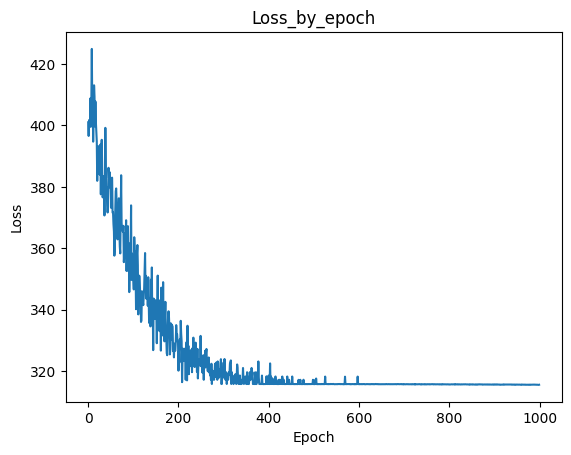

In [16]:
plot_model_training(epoch_history, loss_history)

In [17]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 8.6092e-01, -8.0589e-02,  2.7270e-03,  3.4374e-03,  5.3705e-02,
          8.9701e-02,  2.2809e-03,  2.5087e-02, -6.3410e-03,  1.3105e-02,
          1.7733e-15, -4.6394e-04,  1.0469e-02, -1.8834e-01],
        [-1.3560e-05,  9.8911e-01, -6.8703e-18, -3.0677e-02,  1.3288e-01,
          1.6568e-01, -3.1661e-02,  1.9519e-01,  3.0205e-01, -4.9571e-03,
         -8.4522e-26,  2.8751e-07, -9.6402e-02, -6.7017e-03],
        [-2.2762e-03,  3.1661e-02,  7.7149e-01, -3.9820e-02,  5.0274e-02,
         -1.5467e-01,  1.8876e-02, -6.2497e-02, -2.2805e-07, -1.3500e-04,
         -1.2608e-03, -2.3224e-03, -1.7289e-02,  6.9386e-02],
        [ 9.3985e-03,  4.0032e-02,  5.8563e-02,  1.1472e+00,  2.1909e-02,
          6.8647e-02,  6.6437e-03, -7.6967e-02,  8.9462e-27,  3.2565e-03,
         -3.7125e-04,  1.2167e-24,  1.2678e-01, -3.8272e-02],
        [ 1.8988e-04, -2.5194e-02, -1.0576e-01, -6.6779e-04,  1.0057e+00,
          1.3503e-01, -1.8444e-04,  7.5403e-03,  2.1363e